In [1]:
is_skip = True

# Data params
batch_size = 128
min_encode_len = 60
max_encode_len = 60
pred_len = 10
cheat = 1

valid_start_date = "2020-01-01"

# Model params
d_model = 128
nhead = 4
d_ff = 128
dropout = 0.1
num_layers = 1

# Import

In [2]:
import joblib
import copy
import time

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

device = torch.device("cuda:0")
# device = torch.device("cpu")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [4]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)

class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x
    
    def inverse_transform(self, x, y=None):
        return x

In [5]:
def preprocess(data, df_meta, min_size, is_train=True):
    data = data.copy()
    static_cols = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

   # Make sales
    data = data.groupby(["t_dat", "article_id", *static_cols], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))

   # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0) # Make sure the original data has no zero
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")

   # Diff
    data["shift"] = data["sales"].shift(1)
    data["diff"] = data["sales"] - data["shift"]

   # Accumulate sales
    data = data.sort_values(["article_id", "t_dat"]).reset_index(drop=True)
    data["accm"] = data.groupby("article_id")["sales"].cumsum()

   # Scaler
    if is_train:
        scaler_li = {}
        for col in ["sales", "diff", "accm"]:
            scaler =  MinMaxScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_minmax"] = scaler

            scaler =  StandardScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_standard"] = scaler
            
            scaler =  RobustScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_robust"] = scaler
            
            scaler = LogScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_log"] = scaler

            scaler = NoneScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_none"] = scaler
    else: scaler_li = None

   # Temporal information
   # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year - data["t_dat"].dt.year.min()
    
   # Data to list
    data = data.groupby("article_id", as_index=False)[["sales", "diff", "accm", "price"] + ["day", "dow", "month", "year"]].agg(list)

   # Size restriction
    data["size"] = data["sales"].str.len()

   # Output
    return data, static_cols, scaler_li

if not is_skip:
    # df_prep = df_raw[df_raw["index_name"] == "Ladieswear"]
    df_prep = df_raw.copy()

    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train, static_cols, scaler_li = preprocess(df_train, df_meta, min_size=min_encode_len+pred_len)
    df_train.to_parquet("df_train.pq")
    joblib.dump(static_cols, "static_cols.pkl")
    joblib.dump(scaler_li, "scaler_li.pkl")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid, _, _ = preprocess(df_valid, df_meta, min_size=min_encode_len+pred_len)
    df_valid.to_parquet("df_valid.pq")

### Dataset

<< Encoder >>
hist_input: torch.Size([128, 61])
day_input: torch.Size([128, 61])
padding_mask: torch.Size([128, 61])
valid_seq_len: [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<< Decoder >>
y: torch.Size([128, 11])
day_output: torch.Size([128, 11])


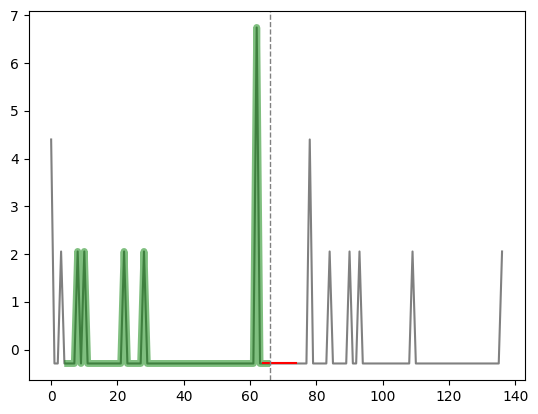

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
df_train = df_train[df_train["size"] >= min_encode_len+pred_len]
df_valid = df_valid[df_valid["size"] >= min_encode_len+pred_len]

static_cols = joblib.load("static_cols.pkl")
scaler_li = joblib.load("scaler_li.pkl")
target_col = "sales"
scaler_name = "none"
scaler_name = f"{target_col}_{scaler_name}"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target_col, min_encode_len, max_encode_len, pred_len, scaler):
        self.min_encode_len, self.max_encode_len, self.pred_len, self.scaler = min_encode_len, max_encode_len, pred_len, scaler

        self.target = data[target_col].values
        self.day = data["day"].values
        self.dow = data["dow"].values
        self.month = data["month"].values
        self.year = data["year"].values
        self.price = data["price"].values
    
    def __len__(self):
        return self.target.shape[0]
    
    def get_output_idx(self, seq_len):
        idx_seq = np.arange(0, seq_len)
        filtered_idx_seq = np.where(
                            (idx_seq >= self.min_encode_len)
                            &(idx_seq <= seq_len - self.pred_len)
                            )[0]
        output_start_idx = np.random.randint(filtered_idx_seq[0], filtered_idx_seq[-1]+1)
        output_idx_raw = idx_seq[output_start_idx : output_start_idx+self.pred_len]
        output_idx = idx_seq[output_start_idx-cheat : output_start_idx+self.pred_len]
        return output_idx, output_idx_raw
    
    def get_input_idx(self, output_start_idx, seq_len):
        idx_seq = np.arange(0, seq_len)
        input_len = np.random.randint(self.min_encode_len, min(output_start_idx, self.max_encode_len)+1)
        input_start_idx = output_start_idx - input_len
        input_idx = idx_seq[input_start_idx:input_start_idx+input_len+cheat]

        return input_idx

    def __getitem__(self, idx):
        target = self.target[idx]
        scaler = StandardScaler()
        target = scaler.fit_transform(target.reshape(-1,1)).reshape(-1)
        day, dow, month, year, price = self.day[idx], self.dow[idx], self.month[idx], self.year[idx], self.price[idx]

        # Input output split
        output_idx, output_idx_raw = self.get_output_idx(target.shape[0])
        input_idx = self.get_input_idx(output_idx_raw[0], target.shape[0])
        
        # Slice data
        hist_input = target[input_idx]
        day_input, dow_input, month_input, year_input, price_input = day[input_idx], dow[input_idx], month[input_idx], year[input_idx], price[input_idx]

        y = target[output_idx]
        day_output, dow_output, month_output, year_output, price_output = day[output_idx], dow[output_idx], month[output_idx], year[output_idx], price[output_idx]

        # Scale data
        hist_input_scaled = self.scaler.transform(hist_input.reshape(-1,1)).reshape(-1)
        y_scaled = self.scaler.transform(y.reshape(-1,1)).reshape(-1)

        # Make sure data has no Nan
        assert not np.isnan(hist_input_scaled).all()\
                and not np.isnan(y_scaled).all()\

        return {# Encoder
                "hist_input": torch.Tensor(hist_input_scaled), 
                "day_input": torch.IntTensor(day_input), "dow_input": torch.IntTensor(dow_input), "month_input": torch.IntTensor(month_input), "year_input": torch.IntTensor(year_input), "price_input": torch.Tensor(price_input),
                
                # Decoder
                "y": torch.Tensor(y_scaled),
                "day_output": torch.IntTensor(day_output), "dow_output": torch.IntTensor(dow_output), "month_output": torch.IntTensor(month_output), "year_output": torch.IntTensor(year_output),

                # Plot
                "total_seq": target, "input_idx": input_idx, "output_idx": output_idx,

                # Loss mask
                "y_original": torch.Tensor(y)}

def collate_fn(batch_li):
    # Encoder
    hist_input = [batch["hist_input"] for batch in batch_li]
    day_input = [batch["day_input"] for batch in batch_li]
    dow_input = [batch["dow_input"] for batch in batch_li]
    month_input = [batch["month_input"] for batch in batch_li]
    year_input = [batch["year_input"] for batch in batch_li]
    price_input = [batch["price_input"] for batch in batch_li]

    # Decoder
    y = torch.stack([batch["y"] for batch in batch_li])
    day_output = torch.stack([batch["day_output"] for batch in batch_li])
    dow_output = torch.stack([batch["dow_output"] for batch in batch_li])
    month_output = torch.stack([batch["month_output"] for batch in batch_li])
    year_output = torch.stack([batch["year_output"] for batch in batch_li])

    # Plot & Loss mask
    total_seq = [batch["total_seq"] for batch in batch_li]
    input_idx = [batch["input_idx"] for batch in batch_li]
    output_idx = [batch["output_idx"] for batch in batch_li]
    y_original = [batch["y_original"] for batch in batch_li]

    # Padding mask
    temporary_padding = torch.nn.utils.rnn.pad_sequence(hist_input, padding_value=torch.nan, batch_first=True)
    padding_mask = torch.where(torch.isnan(temporary_padding), -torch.inf, 0)

    # Padding
    valid_seq_len = [len(row) for row in hist_input]
    hist_input = torch.nn.utils.rnn.pad_sequence(hist_input, padding_value=0, batch_first=True)
    day_input = torch.nn.utils.rnn.pad_sequence(day_input, padding_value=0, batch_first=True)
    dow_input = torch.nn.utils.rnn.pad_sequence(dow_input, padding_value=0, batch_first=True)
    month_input = torch.nn.utils.rnn.pad_sequence(month_input, padding_value=0, batch_first=True)
    year_input = torch.nn.utils.rnn.pad_sequence(year_input, padding_value=0, batch_first=True)
    price_input = torch.nn.utils.rnn.pad_sequence(price_input, padding_value=0, batch_first=True)

    return {# Encoder
            "hist_input": hist_input,
            "day_input": day_input, "dow_input": dow_input, "month_input": month_input, "year_input": year_input, "price_input": price_input,
            "padding_mask": padding_mask, "valid_seq_len": valid_seq_len,
            
            # Decoder
            "y": y,
            "day_output": day_output, "dow_output": dow_output, "month_output": month_output, "year_output": year_output,

            # Plot
            "total_seq": total_seq, "input_idx": input_idx, "output_idx": output_idx,

            # Loss mask
            "y_original": y}
    
train_dataset = Dataset(df_train, target_col, min_encode_len, max_encode_len, pred_len, scaler_li[scaler_name])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid = Dataset(df_valid, target_col, min_encode_len, max_encode_len, pred_len, scaler_li[scaler_name])
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

def plot_sample(total_seq, input_seq, input_idx, pred_seq, pred_idx, scaler, sample_idx=-1):
    # Unpack and inverse transform
    input_idx = input_idx[sample_idx]
    input_seq = input_seq[sample_idx][:len(input_idx)]
    # input_seq = scaler.inverse_transform(input_seq.reshape(-1,1)).reshape(input_seq.shape).squeeze(-1)
    input_seq = scaler.inverse_transform(input_seq.reshape(-1,1)).reshape(input_seq.shape)
    
    pred_idx = pred_idx[sample_idx]
    pred_seq = pred_seq[sample_idx][:len(pred_idx)]
    pred_seq = scaler.inverse_transform(pred_seq.reshape(-1,1)).reshape(pred_seq.shape)

    # Make dataframe
    df_total_seq = pd.DataFrame({"total_seq":total_seq[sample_idx]}).reset_index()
    df_input_seq = pd.DataFrame({"input_seq":input_seq, "index":input_idx})
    df_pred_seq = pd.DataFrame({"pred_seq":pred_seq, "index":pred_idx})
    df = df_total_seq.merge(df_input_seq, on="index", how="outer").merge(df_pred_seq, on="index", how="outer")

    # Plot
    plt.plot(df["total_seq"], color="gray")
    plt.plot(df["input_seq"], color="green", alpha=0.5, linewidth=5)
    plt.plot(df["pred_seq"], color="red")
    plt.axvline(pred_idx[cheat*2], linestyle="--", linewidth=1, color="gray")

for data in train_dataloader:
    print("<< Encoder >>")
    print("hist_input:", data["hist_input"].shape)
    print("day_input:", data["day_input"].shape)
    print("padding_mask:", data["padding_mask"].shape)
    print("valid_seq_len:", data["valid_seq_len"])

    print("<< Decoder >>")
    print("y:", data["y"].shape)
    print("day_output:", data["day_output"].shape)
    break

plot_sample(
        total_seq = data["total_seq"],
        input_seq = data["hist_input"],
        input_idx = data["input_idx"],
        pred_seq = data["y"],
        pred_idx = data["output_idx"],
        scaler = scaler_li[scaler_name]
        )

# Architecture

In [7]:
def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first: raise
        else:
            self_attn_output, self_attn_weight = self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = self.norm1(x + self_attn_output)

            cross_attn_output, cross_attn_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm2(x + cross_attn_output)
            x = self.norm3(x + self._ff_block(x))
        return x, self_attn_weight, cross_attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, self_attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=True)
        return self.dropout1(x), self_attn_weight

    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        x, cross_attn_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True)
        return self.dropout2(x), cross_attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for mod in self.layers:
            output, self_attn_weight, cross_attn_weight = mod(output, memory, tgt_mask=tgt_mask,
                                                            memory_mask=memory_mask,
                                                            tgt_key_padding_mask=tgt_key_padding_mask,
                                                            memory_key_padding_mask=memory_key_padding_mask,
                                                            tgt_is_causal=tgt_is_causal,
                                                            memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, self_attn_weight, cross_attn_weight

class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.hist_lstm = torch.nn.LSTM(1, d_model, batch_first=True, num_layers=num_layers)
        
        self.day_embedder = torch.nn.Embedding(num_embeddings=365, embedding_dim=d_model)
        self.dow_embedder = torch.nn.Embedding(num_embeddings=7, embedding_dim=d_model)
        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)
        self.price_linear = torch.nn.Linear(1, d_model)
        self.concat_layernorm = torch.nn.LayerNorm(d_model)
        self.flatten = torch.nn.Flatten()
        self.encoder_linear = torch.nn.Linear(d_model*(max_encode_len+cheat), d_model*(pred_len+cheat))

        self.temporal_encoder1 = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)
        self.temporal_encoder2 = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)

        self.encoder = Decoder(DecoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)
        self.decoder1 = Decoder(DecoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)
        self.decoder2 = Decoder(DecoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)

        self.final_linear1 = torch.nn.Linear(d_model*(pred_len+cheat), d_model)
        self.final_linear2 = torch.nn.Linear(d_model, pred_len+cheat)


    def get_temporal_mask(self, kind, query_seq, key_seq):
        mask = torch.zeros(query_seq, kind*key_seq).to(device) + -torch.inf
        for i in range(mask.shape[0]):
            mask[i, kind*i : kind*i+kind] = 0
        return mask
    
    def get_temporal_encoder_mask(self, kind, t):
        mask = torch.zeros(kind*t, kind*t).to(device) + -torch.inf
        for i in range(mask.shape[0]):
            mask[i, kind*(i//kind) : kind*(i//kind)+kind] = 0
        return mask

    def forward(self, 
                # Encoder
                hist_input, valid_seq_len, padding_mask,
                day_input, dow_input, month_input, price_input,
                # Decoder
                day_output, dow_output, month_output):
        # Preprocess hist
        hist_input = torch.nn.utils.rnn.pack_padded_sequence(hist_input.unsqueeze(-1), valid_seq_len, batch_first=True, enforce_sorted=False)
        hist_lstm_output = torch.nn.utils.rnn.pad_packed_sequence(self.hist_lstm(hist_input)[0], batch_first=True)[0]
        hist_padding_mask = padding_mask

        # Preprocess temporal input
        day_input = self.day_embedder(day_input)
        dow_input = self.dow_embedder(dow_input)
        month_input = self.month_embedder(month_input)
        price_input = self.price_linear(price_input.unsqueeze(-1))
        temporal_input = self.relu(torch.concat([day_input, dow_input, month_input, price_input], dim=1))
        temporal_input = self.concat_layernorm(temporal_input)

        temporal_input_mask = self.get_temporal_mask(kind=4, query_seq=hist_lstm_output.shape[1], key_seq=hist_lstm_output.shape[1])

        # Encoder
        encoder_output, self_attn_weight, cross_attn_weight = self.encoder(tgt=hist_lstm_output, memory=temporal_input, memory_mask=temporal_input_mask, tgt_key_padding_mask=padding_mask)

        # Decoder
        decoder_input = self.flatten(encoder_output)
        decoder_input = self.encoder_linear(decoder_input).view(-1, pred_len+cheat, d_model)
        
        day_output = self.day_embedder(day_output)
        dow_output = self.dow_embedder(dow_output)
        month_output = self.month_embedder(month_output)
        temporal_output = torch.concat([day_output, dow_output, month_output], dim=1)
        temporal_output_mask1 = self.get_temporal_mask(kind=3, query_seq=pred_len+cheat, key_seq=pred_len+cheat)
        temporal_output_mask2 = self.get_temporal_mask(kind=3, query_seq=pred_len+cheat, key_seq=hist_lstm_output.shape[1])

        decoder_output, self_attn_weight, temporal_cross_attn_weight = self.decoder1(tgt=decoder_input, memory=temporal_output, memory_mask=temporal_output_mask1)
        decoder_output, self_attn_weight, hist_cross_attn_weight = self.decoder2(tgt=decoder_output, memory=encoder_output, memory_key_padding_mask=padding_mask)
        output = self.final_linear2(self.final_linear1(self.flatten(decoder_output)))
        
        return output.squeeze(-1), temporal_cross_attn_weight, hist_cross_attn_weight
        


model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["hist_input"].to(device),
        data["valid_seq_len"],
        data["padding_mask"].to(device),
        data["day_input"].to(device), data["dow_input"].to(device), data["month_input"].to(device), data["price_input"].to(device),
        data["day_output"].to(device), data["dow_output"].to(device), data["month_output"].to(device),
        show_parent_layers=True, print_summary=True)

-------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                                                      Output Shape         Param #     Tr. Param #
     Transformer             LSTM-1     [7808, 128], [61], [128], [128], [1, 128, 128], [1, 128, 128]          67,072          67,072
     Transformer        Embedding-2                                                    [128, 61, 128]          46,720          46,720
     Transformer        Embedding-3                                                    [128, 61, 128]             896             896
     Transformer        Embedding-4                                                    [128, 61, 128]           1,536           1,536
     Transformer           Linear-5                                                    [128, 61, 128]             256             256
     Transformer             ReLU-6                           

'-------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                                                      Output Shape         Param #     Tr. Param #\n=====================================================================================================================================\n     Transformer             LSTM-1     [7808, 128], [61], [128], [128], [1, 128, 128], [1, 128, 128]          67,072          67,072\n     Transformer        Embedding-2                                                    [128, 61, 128]          46,720          46,720\n     Transformer        Embedding-3                                                    [128, 61, 128]             896             896\n     Transformer        Embedding-4                                                    [128, 61, 128]           1,536           1,536\n     Transformer           Linear-5                   

# Train

epoch 4 - loss: 0.4879996344447136


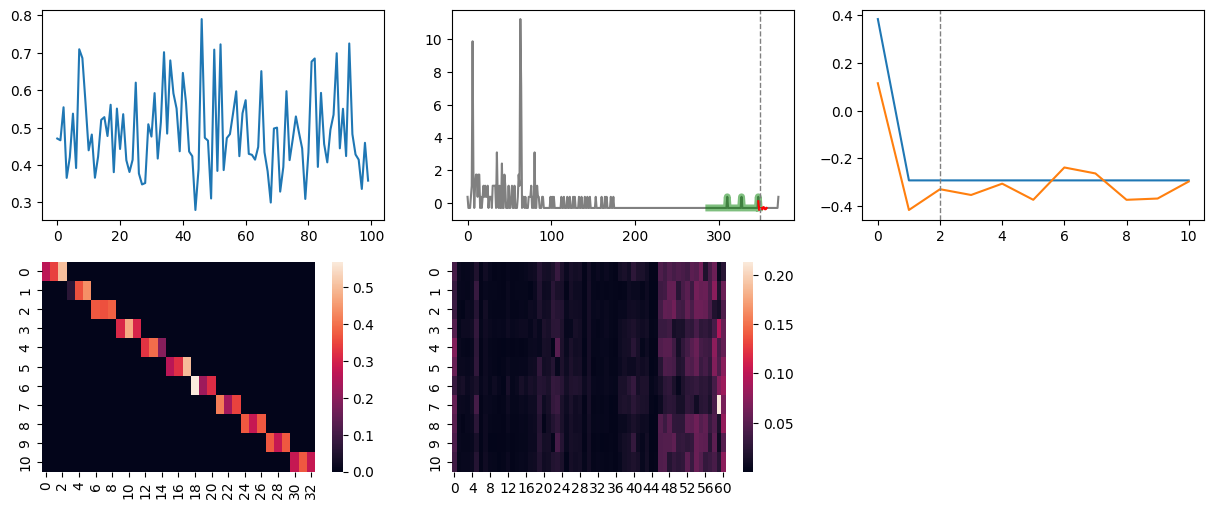

100%|██████████| 488/488 [00:21<00:00, 22.33it/s]


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# mse_loss = torch.nn.MSELoss(reduction="none")
mse_loss = torch.nn.MSELoss()

# batch_size = 16

def mse_loss_fn(pred, y, y_original):
    mask = torch.where(y_original==0, 0, 1).type(torch.FloatTensor).to(device).unsqueeze(-1)
    loss = mse_loss(pred, y)
    masked_loss = loss * mask
    
    loss = masked_loss.sum() / mask.sum()
    return loss

def report(data, pred, self_attn_weight, cross_attn_weight, window, loss_li, is_plot=True):
    sample_idx = -1
    clear_output(wait=True)
    print(f"epoch {e} - loss: {np.mean(loss_li[-window:])}")
    
    if is_plot:
        plt.figure(figsize=(15,6))
        nrows, ncols = 2, 3

       # Plot loss
        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li[-window:])
        
       # Plot sample (full size)
        plt.subplot(nrows, ncols, 2)
        plot_sample(
                total_seq = data["total_seq"],
                input_seq = data["hist_input"],
                input_idx = data["input_idx"],
                pred_seq = pred.detach().cpu(),
                pred_idx = data["output_idx"],
                scaler = scaler_li[scaler_name],
                sample_idx = sample_idx
                )
       
       # Plot sample (in detail)
        plt.subplot(nrows, ncols, 3)
        plt.plot(data["y"][sample_idx])
        plt.plot(pred[sample_idx].squeeze(-1).detach().cpu().numpy())
        plt.axvline(cheat*2, linestyle="--", linewidth=1, color="gray")
    
       # Plot self attention
        plt.subplot(nrows, ncols, 4)
        self_attn_weight = self_attn_weight[sample_idx].detach().cpu()
        sns.heatmap(self_attn_weight)

        # Plot cross attention
        plt.subplot(nrows, ncols, 5)
        cross_attn_weight = cross_attn_weight[sample_idx].detach().cpu()
        sns.heatmap(cross_attn_weight)

        plt.show()

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, self_attn_weight, cross_attn_weight = model(
                                                    data["hist_input"].to(device),
                                                    data["valid_seq_len"],
                                                    data["padding_mask"].to(device),
                                                    data["day_input"].to(device), data["dow_input"].to(device), data["month_input"].to(device), data["price_input"].to(device),
                                                    data["day_output"].to(device), data["dow_output"].to(device), data["month_output"].to(device),
                                                        )
        # loss = mse_loss_fn(pred, data["y"].to(device), data["y_original"])
        loss = mse_loss(pred, data["y"].to(device))
        loss_li.append(loss.item())
        loss.backward()
        optimizer.step()

        if n % 50 == 0:
            report(data, pred, self_attn_weight, cross_attn_weight, window, loss_li, is_plot=True)
    return model, np.mean(loss_li[-window:])

epoch = 5
for e in range(epoch):
    model, loss = train(e)